In [44]:
import os
import random
import sys

from functools import reduce
from numpy import subtract, floor_divide
    
from PIL import Image, ImageDraw, ImageFont

In [40]:
# globals
CHARSET_SIZE = 0
# IMAGE_DIR = os.environ.get('PONCO_IMAGE_DIR')
# FONT_DIR = os.environ.get('PONCO_FONT_DIR')

if not FONT_DIR or not IMAGE_DIR:
    print("FONT_DIR or IMAGE_DIR environment variable is missing", file=sys.stderr)
    # exit(1)

FONT_DIR = '/home/macermak/code/thesis/char-generator/fonts'  # FIXME
IMAGE_DIR = '/home/macermak/code/thesis/char-generator/images'  # FIXME
    
# Create directories if not exist
if not os.path.isdir(FONT_DIR):
    os.mkdir(FONT_DIR)
if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

In [3]:
def estimate_font_size(ttf, text, fit_size, font_size=20, eps=8):
    font = ImageFont.truetype(font=ttf, encoding='utf-8', size=font_size)

    w, h = font.getsize(text)
    _err = max(fit_size) - max(w, h)
    
    while abs(_err) > eps:
        w, h = font.getsize(text)
        _err = max(fit_size) - max(w, h)
        
        font_size += 1 if _err > 0 else -1
        font = ImageFont.truetype(font=ttf, encoding='utf-8', size=int(font_size))
    
    return font

In [4]:
def load_char_set() -> list:
    """Load characters that are allowed from the charset.txt file."""
    with open('charset.txt') as f:
        chars = f.read().split()

    global CHARSET_SIZE
    CHARSET_SIZE = len(chars)

    return chars

In [5]:
def load_font_set() -> list:
    """Walk through the default font directory and search for font files."""
    import re
    fnames = []
    for root, _, files in os.walk(FONT_DIR):
        fnames.extend(os.path.join(root, f) for f in files if re.match(r'(.+)\.[odtfOTF]{3}', f))

    return fnames

In [6]:
def create_whiteboard(color='#f4f4f4', sample_size=(32, 32)) -> Image.Image:
    """Computes and Creates white board (background) for the given font."""
    # a bit of a cheating here - charset size is 210 (15 x 14)
    bg_size = (15 * sample_size[0], 14 * sample_size[1])

    return Image.new(mode='RGBA', size=bg_size, color=color)

In [105]:
def get_text_loc_in_sample(text, font: "ImageFont.font", sample_size, offset='random'):
    """Calculates location of text on the given sample background."""
    fo_x, fo_y = font.getoffset(text)
    if offset == 'random':
        # add a little bit of entropy
        rand_factor = min(sample_size) // 10
        font_offset = (
                fo_x + random.randint(-rand_factor, rand_factor),
                fo_y + random.randint(-rand_factor, rand_factor),
        )
        
    # location of char in the sample
    char_loc = reduce(subtract, (sample_size, font.getsize(text), font_offset))
    char_loc = floor_divide(char_loc, 2)
    
    return char_loc

In [7]:
def create_fontboard(charset: list, fontset: list, sample_size=(32, 32)):
    """Create fontboard for each font provided in fontset and saves it as .png into IMG_DIR.
    Characters given by charset are drawn on the board
    """
    import re

    if not fontset:
        print("Empty argument provided: fontset - ", fontset, file=sys.stderr)

    board = create_whiteboard(sample_size=sample_size)
    fontboard_dir = "{path}/fontboard".format(path=IMAGE_DIR)
    # Make sure fontboard directory exists
    if not os.path.isdir(fontboard_dir):
        os.mkdir(fontboard_dir)

    for font_file in fontset:
        font_name = re.search(r"([^/]+)\.(\w+)$", font_file).group(1)
        board_name = "{path}/{ttf}-board.png".format(
                path=fontboard_dir,
                ttf=font_name)
        if os.path.isfile(board_name):
            print('Skipping', board_name)
            continue

        print("Creating board", board_name, "...") 
        font_board = board.copy()
        try:
            font = estimate_font_size(
                    ttf=font_file,
                    text=text,  # for sake of performance, assume that what works
                               # for H, works for everything else
                    fit_size=(32, 32),
                    eps=max(sample_size) // 10
                    )
        except OSError as e:
            print("Skipping", font_file, e.args)
            
        draw = ImageDraw.Draw(font_board)

        init_pos = (0, 0)
        for char in charset:
            # position of char in the sample
            char_loc = get_text_loc_in_sample(text=char, font=font)
            
            # position of char on the board
            char_pos = init_pos + char_loc
            draw.text(
                    xy=char_pos,
                    text=char,
                    font=font,
                    fill="black"
                    )

            if init_pos[0] + sample_size[0] >= board.size[0]:
                init_pos = (0, init_pos[1] + sample_size[1])
            else:
                init_pos = (init_pos[0] + sample_size[0], init_pos[1])

        # save the board
        font_board.save(fp=board_name)
        print('Written', board_name)

In [68]:
def generate_char_image(char, font_file, sample_size=(32, 32), bgcolor='#f6f6f6', fontcolor='black'):
    """Generate image of given size and font for each character."""
    try:
        font = estimate_font_size(
                ttf=font_file,
                text=char,  # for sake of performance, assume that what works
                           # for H, works for everything else
                fit_size=(32, 32),
                eps=max(sample_size) // 10
                )
    except OSError as e:
        print("Skipping", font_file, e.args)

    char_bg = Image.new(mode='RGBA', color=bgcolor, size=sample_size)
    draw = ImageDraw.Draw(char_bg)
    
    char_loc = get_text_loc_in_sample(text=char, font=font, sample_size=sample_size)
    draw.text(
            xy=char_loc,
            text=char,
            font=font,
            fill=fontcolor
            )
    
    return char_bg

In [ ]:
def generate_and_save_charsets(charset, fontset, sample_size=(32, 32), bgcolor='#f6f6f6', fontcolor='black'):
    """Generate char images from charset for each font in fontset."""
    import re
    charset_dir = "{path}/charsets".format(path=IMAGE_DIR)
    char_file_path = "{path}/{char}.png"
    # Make sure charset dir exists
    if os.path.isdir(charset_dir):
        os.mkdir(charset_dir)
        
    for font_file in fontset:
        # Create font specifi directory inside charset dir
        font_name = re.search(r"([^/]+)\.(\w+)$", font_file).group(1)
        fontset_dir = "{charset_dir}/{font}".format(charset_dir=charset_dir, font=font_name)
        
        if not os.path.isdir(fontset_dir):
            os.mkdir(fontset_dir)
            
        for char in charset:
            char_img = generate_char_image(char, font_file, sample_size, bgcolor, fontcolor)
            char_img.save(fp=char_file_path.format(path=fontset_dir, char=char))


## Tests

In [37]:
charset = load_char_set()
fontset = load_font_set()

font_file = '/home/macermak/code/thesis/char-generator/fonts/Inconsolata/Inconsolata.otf'

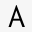

In [112]:
generate_char_image('A', font_file)

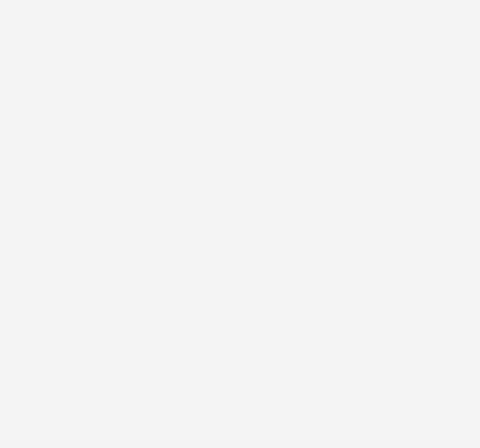

In [9]:
create_whiteboard()

In [41]:
create_fontboard(charset=charset, fontset=[font_file])

Creating board /home/macermak/code/thesis/char-generator/images/Inconsolata-board.png ...
Written /home/macermak/code/thesis/char-generator/images/Inconsolata-board.png


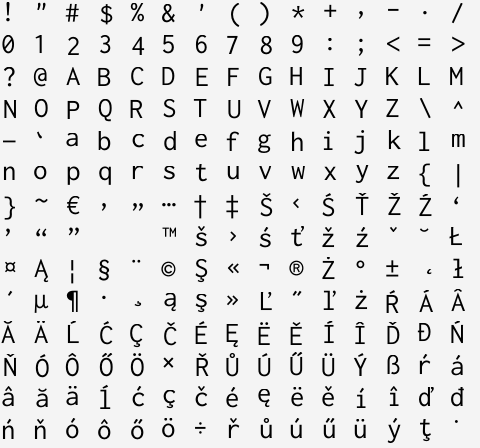

In [42]:
Image.open('/home/macermak/code/thesis/char-generator/images/Inconsolata-board.png')

In [ ]:
if __name__ == '__main__':
    # check image directory
    if not os.path.isdir(IMAGE_DIR):
        os.mkdir(IMAGE_DIR)

    # check fonts directory
    if not os.path.isdir(FONT_DIR):
        print("Missing 'fonts' directory", file=sys.stderr)
        exit(1)

    charset = load_char_set()
    fontset = load_font_set()
    im_size = (32, 32)

    create_fontboard(charset, fontset, sample_size=im_size)